# **Sentiment analysis of the IMBD movie reviews**

# **Loading the dataset**

In [71]:
import pandas as pd
dataset_url = 'https://raw.githubusercontent.com/neeharikasinghsjsu/cmpe272-assignments/main/assignment-6/dataset/sentiment-data.csv'
data = pd.read_csv(dataset_url)

In [72]:
data.head()

,text,label
0,"Very silly movie, filled with stupid one liner...",0
1,"As predictable as a Hallmark card, but not wit...",1
2,"Only a 9/10 from me, a perfect ten would have ...",1
3,"After Watergate, Vietnam and the dark days of ...",0
4,As long as you keep in mind that the productio...,0


In [73]:
data.tail()

,text,label
37925,I have seen this film many times and I like al...,1
37926,When I saw it for the first time I was really ...,1
37927,the reason why i gave this movie a 4 was for a...,0
37928,I'd have to admit that the draw of this movie ...,0
37929,drab morality tale about a high school kid who...,0


**The dataset contains two columns:**

**text** - Movie reviews

**label** - Classification of the reviews as positive (1) and negative(0).

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37930 entries, 0 to 37929
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    37930 non-null  object
 1   label   37930 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 592.8+ KB


In [75]:
missing_values = data.isnull().sum()
missing_values

text     0
label    0
dtype: int64

In [76]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import nltk

print("Dataset size:", data.shape[0])
print("Label distribution:\n", data['label'].value_counts())


Dataset size: 37930
Label distribution:
 0    18978
1    18952
Name: label, dtype: int64


**Plot sentiment distribution in the dataset**

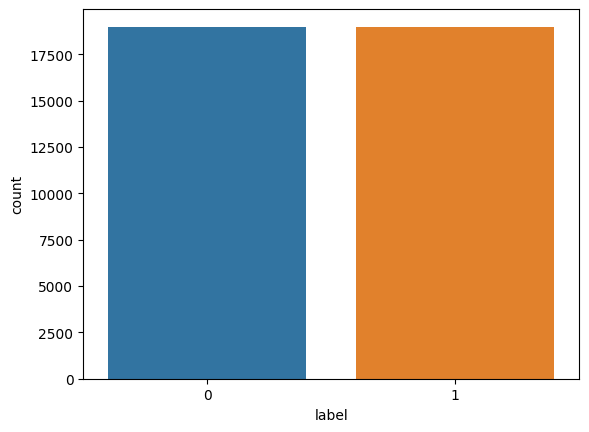

In [77]:
# Visualizing the distribution of sentiments
sns.countplot(x='label', data=data)
plt.show()


**Plot review lengths distribution**

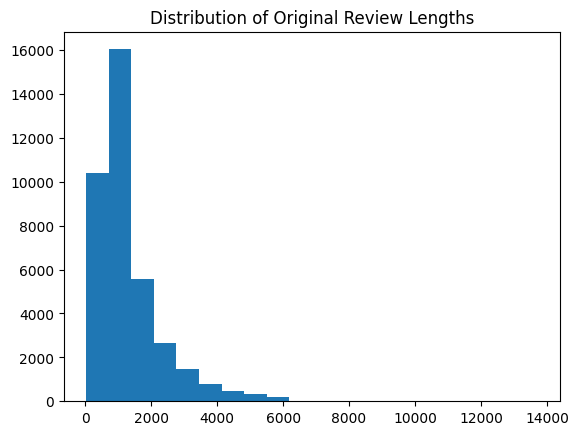

In [78]:
data['review_length'] = data['text'].apply(len)
plt.hist(data['review_length'], bins=20)
plt.title('Distribution of Original Review Lengths')
plt.show()

# **Data Cleaning**

Remove the HTML characters, special characters like punctuation and numbers and converting the text to lowercase

In [79]:
import re

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

data['cleaned_text'] = data['text'].apply(clean_text)

data[['cleaned_text', 'label']].head()


,cleaned_text,label
0,very silly movie filled with stupid one liners...,0
1,as predictable as a hallmark card but not with...,1
2,only a from me a perfect ten would have been ...,1
3,after watergate vietnam and the dark days of t...,0
4,as long as you keep in mind that the productio...,0


# **EDA**

**Word Cloud**

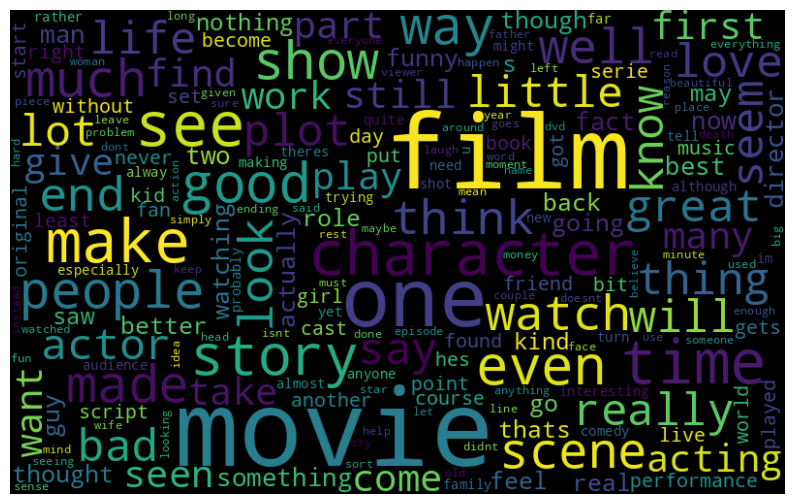

In [80]:
# Text Analysis using cleaned text
# Word Cloud
all_cleaned_words = ' '.join([text for text in data['cleaned_text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_cleaned_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**Bigram most common words from the cleaned text**

In [81]:

# Bigram Analysis with cleaned text
bigrams = Counter(nltk.bigrams(all_cleaned_words.split()))
print(bigrams.most_common(10))

[(('of', 'the'), 58606), (('in', 'the'), 37749), (('this', 'movie'), 22455), (('and', 'the'), 19948), (('is', 'a'), 19737), (('to', 'the'), 17919), (('to', 'be'), 17680), (('the', 'film'), 17661), (('the', 'movie'), 16622), (('this', 'film'), 15453)]


# **Text Preprocessing**

**Tokenization:** Splitting text into individual words.

**Removing Stop Words:** Eliminating common words that may not add much meaning to the analysis.

**Lemmatization:** Reducing words to their base or dictionary form.

In [82]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text)

    tokens = [word for word in tokens if word not in stopwords.words('english')]

    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(lemmatized)

data['preprocessed_text'] = data['cleaned_text'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [83]:
data[['preprocessed_text', 'label']].head()

,preprocessed_text,label
0,silly movie filled stupid one liner jewish ref...,0
1,predictable hallmark card without merit rookie...,1
2,perfect ten would plot movie nevertheless moon...,1
3,watergate vietnam dark day nixon jimmy carter ...,0
4,long keep mind production movie copyright ploy...,0


**Bigram most common words from preprocessed text**

In [84]:

# Bigrams analysis using preprocessed text
all_preprocessed_words = ' '.join([text for text in data['preprocessed_text']])
bigrams = Counter(nltk.bigrams(all_preprocessed_words.split()))
print(bigrams.most_common(10))

[(('look', 'like'), 2237), (('ever', 'seen'), 1944), (('special', 'effect'), 1664), (('ive', 'seen'), 1646), (('dont', 'know'), 1546), (('main', 'character'), 1426), (('even', 'though'), 1424), (('one', 'best'), 1401), (('movie', 'like'), 1311), (('year', 'old'), 1306)]


# **Feature Extraction**
TF-IDF for feature extraction. It involves converting text data to numerical form.

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(data['preprocessed_text'])


Dimension of the resulting feature matrix

In [86]:
X.shape

(37930, 170028)

# **Model Training**

Split the data in training and test set to evaluate the performance of the model.

We will be using the **Logistic Regression** model

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Assuming 'X' is your feature matrix obtained from TF-IDF and 'data['label']' are your labels

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
lr_model = LogisticRegression()

# Train the model with the training data
lr_model.fit(X_train, y_train)


LogisticRegression()

# **Model Evaluation**

In [88]:
# Predict the labels for the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3784
           1       0.88      0.90      0.89      3802

    accuracy                           0.89      7586
   macro avg       0.89      0.89      0.89      7586
weighted avg       0.89      0.89      0.89      7586

Confusion Matrix:
[[3317  467]
 [ 377 3425]]
Accuracy Score:
0.8887424202478249


# **Analyzing the sentiments of the movie reviews generated by Chat GPT**

**load the dataset**

In [100]:
chatgpt_dataset_url = 'https://raw.githubusercontent.com/neeharikasinghsjsu/cmpe272-assignments/main/assignment-6/dataset/chatgpt-generated-movie-reviews.csv'
chatgpt_data = pd.read_csv(chatgpt_dataset_url)

chatgpt_data.head()


,movie-reviews
0,Just watched 'Eternal Echoes' - a stunning ble...
1,"Caught the latest superhero flick, 'Guardians ..."
2,"If you're looking for a heartwarming story, 'T..."
3,Saw 'Mystery at the Manor' last night. The twi...
4,I'm still in awe of 'Stars Beyond'. The cinema...


**Data Cleaning and Data Preprocessing**

In [101]:
chatgpt_data['gpt_cleaned_text'] = chatgpt_data['movie-reviews'].apply(clean_text)
chatgpt_data['gpt_preprocessed_text'] = chatgpt_data['gpt_cleaned_text'].apply(preprocess_text)

In [102]:
chatgpt_data['gpt_cleaned_text'].head()


0    just watched eternal echoes  a stunning blend ...
1    caught the latest superhero flick guardians of...
2    if youre looking for a heartwarming story the ...
3    saw mystery at the manor last night the twist ...
4    im still in awe of stars beyond the cinematogr...
Name: gpt_cleaned_text, dtype: object

In [103]:
chatgpt_data['gpt_preprocessed_text'].head()

0    watched eternal echo stunning blend scifi phil...
1    caught latest superhero flick guardian tomorro...
2    youre looking heartwarming story journey home ...
3    saw mystery manor last night twist unexpected ...
4    im still awe star beyond cinematography world ...
Name: gpt_preprocessed_text, dtype: object

**Feature Extraction**

In [104]:
new_features = vectorizer.transform(chatgpt_data['gpt_preprocessed_text'])

**Sentiment prediction**

In [105]:
predicted_sentiments = lr_model.predict(new_features)

In [106]:
chatgpt_data['predicted_sentiment'] = predicted_sentiments

In [108]:
print(chatgpt_data[['movie-reviews', 'predicted_sentiment']])

                                       movie-reviews  predicted_sentiment
0  Just watched 'Eternal Echoes' - a stunning ble...                    1
1  Caught the latest superhero flick, 'Guardians ...                    1
2  If you're looking for a heartwarming story, 'T...                    1
3  Saw 'Mystery at the Manor' last night. The twi...                    1
4  I'm still in awe of 'Stars Beyond'. The cinema...                    1
5  Laughed non-stop during 'Comedy Central'. It's...                    1
6  The action in 'Fist of Fury: Reloaded' is top-...                    1
7  As a fan of the book, 'Worlds Apart' didn't qu...                    0
8  Just left the theater from 'Dreams of Tomorrow...                    1
9  Director Jane Smith's latest, 'Echoes of the P...                    1
